In [20]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from glob import glob
import pickle

from PIL import ImageColor
import matplotlib.colors
from sklearn.preprocessing import StandardScaler
from utils import LATENT_FEATURES_DIR, RESULTS_DIR, SUBJECTS, FMRI_BETAS_SURFACE_DIR, STIM_INFO_PATH, COCO_IMAGES_DIR, METRIC_DIFF_MOD_AGNOSTIC_MOD_SPECIFIC, METRIC_CROSS_DECODING, DECODER_ADDITIONAL_TEST_OUT_DIR, SUBJECTS_ADDITIONAL_TEST, FMRI_DATA_DIR
from analyses.decoding.ridge_regression_decoding import NUM_CV_SPLITS, pairwise_accuracy
from data import MODALITY_AGNOSTIC, MODALITY_SPECIFIC_IMAGES, MODALITY_SPECIFIC_CAPTIONS, TRAINING_MODES, CAPTION, IMAGE, SPLIT_TRAIN, TEST_SPLITS, SPLIT_IMAGERY, SPLIT_IMAGERY_WEAK, SPLIT_TEST_IMAGES, SPLIT_TEST_CAPTIONS, LatentFeatsConfig, get_stim_info, get_latents_for_splits, standardize_latents
from eval import ACC_MODALITY_AGNOSTIC, ACC_CAPTIONS, ACC_IMAGES, ACC_CROSS_IMAGES_TO_CAPTIONS, ACC_CROSS_CAPTIONS_TO_IMAGES, ACC_IMAGERY, ACC_IMAGERY_WHOLE_TEST, get_distance_matrix
from scipy.stats import ttest_rel
import statsmodels.formula.api as smf
from scipy.spatial.distance import cdist

from notebook_utils import load_predictions

In [2]:
def load_results_data():
    data = []

    result_files = sorted(glob(f"{DECODER_ADDITIONAL_TEST_OUT_DIR}/*/*/*/results.csv"))
    for result_file_path in tqdm(result_files):
        results = pd.read_csv(result_file_path)
        data.append(results)

    data = pd.concat(data, ignore_index=True)
    data["mask"] = data["mask"].fillna("whole_brain")

    return data

data = load_results_data()

# with pd.option_context('display.max_rows', None, 'display.max_columns', None):
display(data)

print(f"Subjects: {data.subject.unique()}")

100%|██████████| 43/43 [00:00<00:00, 386.85it/s]


,metric,value,standardized_predictions,latents,model,subject,features,test_features,vision_features,lang_features,training_mode,training_splits,mask,num_voxels,surface,resolution,imagery_samples_weight
0,test_image,0.901863,True,limited_candidate_latents,imagebind,sub-01,avg,avg,vision_features_cls,lang_features_cls,agnostic,train,whole_brain,133499,False,fsaverage7,NaN
1,test_image,0.896273,False,limited_candidate_latents,imagebind,sub-01,avg,avg,vision_features_cls,lang_features_cls,agnostic,train,whole_brain,133499,False,fsaverage7,NaN
2,test_image,0.903044,True,all_candidate_latents,imagebind,sub-01,avg,avg,vision_features_cls,lang_features_cls,agnostic,train,whole_brain,133499,False,fsaverage7,NaN
3,test_image,0.911358,False,all_candidate_latents,imagebind,sub-01,avg,avg,vision_features_cls,lang_features_cls,agnostic,train,whole_brain,133499,False,fsaverage7,NaN
4,test_caption,0.759627,True,limited_candidate_latents,imagebind,sub-01,avg,avg,vision_features_cls,lang_features_cls,agnostic,train,whole_brain,133499,False,fsaverage7,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1457,imagery_weak,0.899592,True,limited_candidate_latents,imagebind,sub-07,avg,avg,vision_features_cls,lang_features_cls,images,train,whole_brain,327684,True,fsaverage7,NaN
1458,imagery_weak,0.648361,False,all_candidate_latents,imagebind,sub-07,avg,avg,vision_features_cls,lang_features_cls,images,train,whole_brain,327684,True,fsaverage7,NaN
1459,imagery_weak,0.885574,True,all_candidate_latents,imagebind,sub-07,avg,avg,vision_features_cls,lang_features_cls,images,train,whole_brain,327684,True,fsaverage7,NaN
1460,imagery,0.666667,all_imagery,limited_candidate_latents,imagebind,sub-07,avg,avg,vision_features_cls,lang_features_cls,images,train,whole_brain,327684,True,fsaverage7,NaN


Subjects: ['sub-01' 'sub-02' 'sub-05' 'sub-07']


In [3]:
print(data[(data.subject == 'sub-01') & (data.model == 'imagebind') & (data.training_mode == 'agnostic') & (data['mask'] == 'whole_brain') & (data.standardized_predictions == 'True') & (data.training_splits == 'train')][['metric', 'value', 'latents']]) #
# print(data[(data.subject == 'sub-01') & (data.model == 'imagebind') & (data.training_mode == 'agnostic') & (data['mask'] == 'whole_brain') & (data.training_splits == 'train') & (data.latents == 'all_candidate_latents')][['metric', 'value', 'latents', 'standardized_predictions']]) #

                     metric     value                    latents
0                test_image  0.901863  limited_candidate_latents
2                test_image  0.903044      all_candidate_latents
4              test_caption  0.759627  limited_candidate_latents
6              test_caption  0.763115      all_candidate_latents
8       test_image_attended  0.905590  limited_candidate_latents
10      test_image_attended  0.907143      all_candidate_latents
12    test_caption_attended  0.817598  limited_candidate_latents
14    test_caption_attended  0.816628      all_candidate_latents
16    test_image_unattended  0.896894  limited_candidate_latents
18    test_image_unattended  0.899180      all_candidate_latents
20  test_caption_unattended  0.628571  limited_candidate_latents
22  test_caption_unattended  0.628220      all_candidate_latents
24                  imagery  1.000000  limited_candidate_latents
26                  imagery  0.844262      all_candidate_latents
28             imagery_we

In [27]:
filtered = data.copy()

# LATENT_MODE = 'all_candidate_latents'
LATENT_MODE = 'limited_candidate_latents'
MASK = 'whole_brain'
TRAINING_SPLITS = 'train'
MODEL = 'imagebind'

filtered = filtered[filtered.model == MODEL]
filtered = filtered[filtered.standardized_predictions == 'True']
filtered = filtered[filtered.training_splits == TRAINING_SPLITS]
filtered = filtered[filtered.latents == LATENT_MODE]
filtered = filtered[filtered['mask'] == MASK]
filtered = filtered[filtered.imagery_samples_weight.isna()]
filtered = filtered[filtered.surface == True]

# print(filtered.groupby(['metric', 'training_mode']).agg(num_subjects=('value', 'size')).reset_index())
NUM_SUBJECTS = 4 # len(ADDITIONAL_TEST_SUBJECTS)
expected_len = NUM_SUBJECTS * len(filtered.metric.unique()) * len(filtered.training_mode.unique())
assert len(filtered) == expected_len, filtered

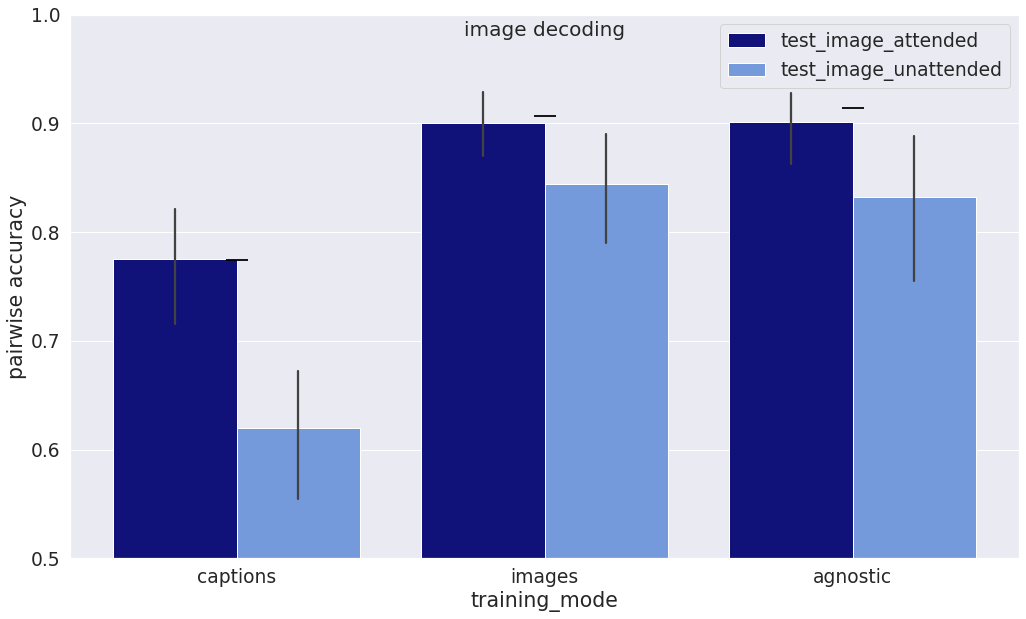

In [28]:
to_plot = filtered.copy()

ORDER = ['captions', 'images', 'agnostic']
HUE_ORDER = ['test_image_attended', 'test_image_unattended']#, 'imagery', 'imagery_weak'] #'test_image', 
PALETTE = ['darkblue', 'cornflowerblue'] #blue

to_plot = to_plot[to_plot.metric.isin(HUE_ORDER)]

sns.set(font_scale=1.7)
plt.figure(figsize=(17, 10))
plt.title('image decoding', y=0.95, fontsize=20)
ax = sns.barplot(data=to_plot, x="training_mode", y="value", hue="metric", order=ORDER, hue_order=HUE_ORDER, palette=PALETTE)
plt.ylim((0.5, 1))
plt.ylabel('pairwise accuracy')


ORDER = ['captions', 'images', 'agnostic']
HUE_ORDER = ['test_image']
to_plot_grouped = filtered.copy()
to_plot_grouped = to_plot_grouped[to_plot_grouped.metric.isin(HUE_ORDER)]
to_plot_grouped = to_plot_grouped.groupby(['training_mode']).agg(value=('value', 'mean')).reset_index()
# display(to_plot)
sns.scatterplot(data=to_plot_grouped, x="training_mode", y="value", marker="_", color='black', s=500)

plt.savefig(os.path.join(RESULTS_DIR, f"attention_modulation_images.png"), bbox_inches='tight', pad_inches=0, dpi=300)



## hypothesis: mod-agnostic decoders (and cross-decoding) should suffer more from missing attention

In [29]:
for_stats = to_plot[to_plot.training_mode.isin(['images', 'agnostic'])]
# display(for_stats)
# print(ttest_rel(for_stats[for_stats.metric == 'test_image_attended'].value, for_stats[for_stats.metric == 'test_image_unattended'].value))

for_stats = for_stats[['model', 'subject', 'training_mode', 'value', 'metric']]

mod = smf.mixedlm("value ~ metric * training_mode", for_stats, groups=for_stats["subject"]).fit()

print("=" * 50 + "\nGLM\n" + "=" * 50)
print(mod.summary())
print('pvalues:\n', mod.pvalues)
print('\n')


GLM
                              Mixed Linear Model Regression Results
Model:                           MixedLM                Dependent Variable:                value  
No. Observations:                16                     Method:                            REML   
No. Groups:                      4                      Scale:                             0.0022 
Min. group size:                 4                      Log-Likelihood:                    15.2297
Max. group size:                 4                      Converged:                         Yes    
Mean group size:                 4.0                                                              
--------------------------------------------------------------------------------------------------
                                                        Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------------------------------------------
Intercept                            

/home/mitja/anaconda3/envs/multimodal_decoding_additional_test/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


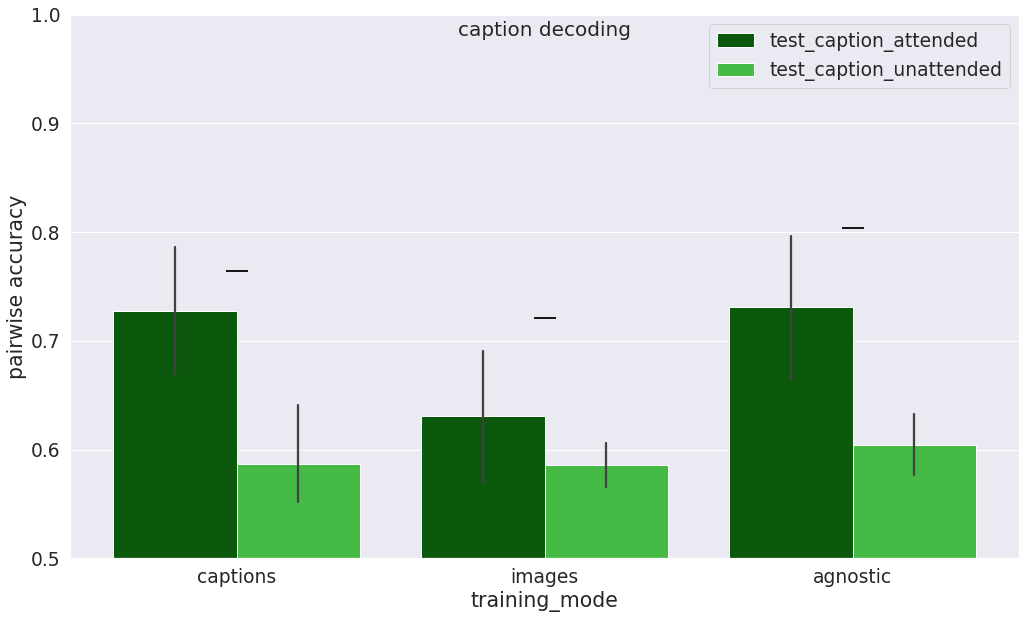

In [30]:
to_plot = filtered.copy()

ORDER = ['captions', 'images', 'agnostic']
HUE_ORDER = ['test_caption_attended', 'test_caption_unattended']#, 'imagery', 'imagery_weak'] #'test_caption', 
PALETTE = ['darkgreen', 'limegreen'] #'green', 

to_plot = to_plot[to_plot.metric.isin(HUE_ORDER)]

sns.set(font_scale=1.7)
plt.figure(figsize=(17,10))
plt.title('caption decoding', y=0.95, fontsize=20)
ax = sns.barplot(data=to_plot, x="training_mode", y="value", hue="metric", order=ORDER, hue_order=HUE_ORDER, palette=PALETTE)
plt.ylabel('pairwise accuracy')
plt.ylim((0.5, 1))

ORDER = ['captions', 'images', 'agnostic']
HUE_ORDER = ['test_caption']
to_plot_grouped = filtered.copy()
to_plot_grouped = to_plot_grouped[to_plot_grouped.metric.isin(HUE_ORDER)]
# display(to_plot)
to_plot_grouped = to_plot_grouped.groupby(['training_mode']).agg(value=('value', 'mean')).reset_index()

sns.scatterplot(data=to_plot_grouped, x="training_mode", y="value", marker="_", color='black', s=500)

plt.savefig(os.path.join(RESULTS_DIR, f"attention_modulation_captions.png"), bbox_inches='tight', pad_inches=0, dpi=300)


In [31]:
for_stats = to_plot[to_plot.training_mode.isin(['captions', 'agnostic'])]
# print(ttest_rel(for_stats[for_stats.metric == 'test_caption_attended'].value, for_stats[for_stats.metric == 'test_caption_unattended'].value))

for_stats = for_stats[['model', 'subject', 'training_mode', 'value', 'metric']]

mod = smf.mixedlm("value ~ metric * training_mode", for_stats, groups=for_stats["subject"]).fit()

print("=" * 50 + "\nGLM\n" + "=" * 50)
print(mod.summary())
print('pvalues:\n', mod.pvalues)
print('\n')



GLM
                                Mixed Linear Model Regression Results
Model:                             MixedLM                 Dependent Variable:                 value  
No. Observations:                  16                      Method:                             REML   
No. Groups:                        4                       Scale:                              0.0010 
Min. group size:                   4                       Log-Likelihood:                     17.9877
Max. group size:                   4                       Converged:                          Yes    
Mean group size:                   4.0                                                                
------------------------------------------------------------------------------------------------------
                                                            Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------------------------------------------

/home/mitja/anaconda3/envs/multimodal_decoding_additional_test/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


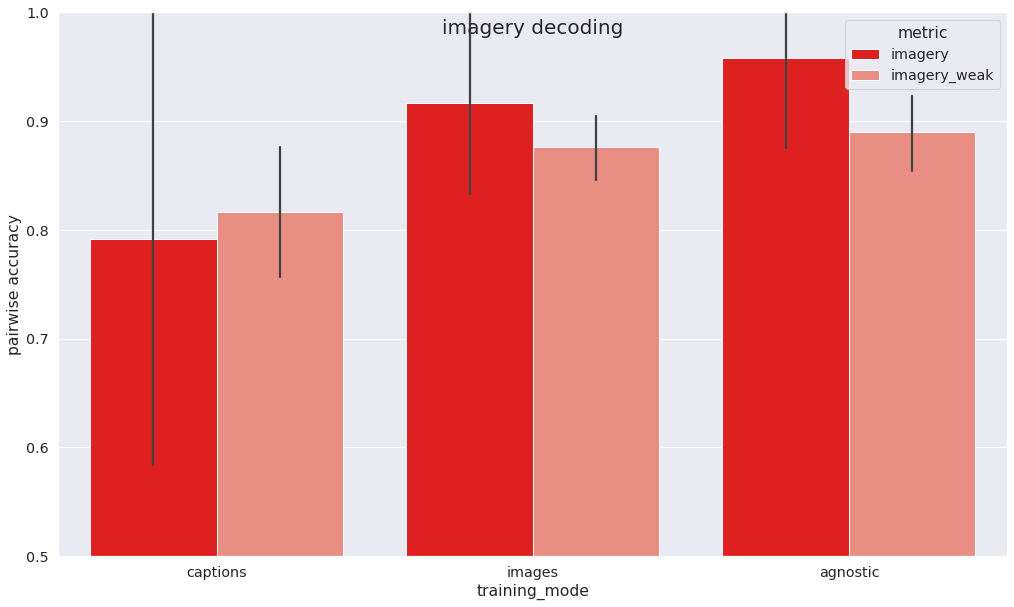

In [32]:
to_plot = filtered.copy()

ORDER = ['captions', 'images', 'agnostic']
HUE_ORDER = ['imagery', 'imagery_weak']
PALETTE = ['red', 'salmon']
sns.set(font_scale=1.3)
plt.figure(figsize=(17,10))
plt.title('imagery decoding', y=0.95, fontsize=20)

ax = sns.barplot(data=to_plot, x="training_mode", y="value", hue="metric", order=ORDER, hue_order=HUE_ORDER, palette=PALETTE)
plt.ylabel('pairwise accuracy')
plt.ylim((0.5, 1))
plt.savefig(os.path.join(RESULTS_DIR, f"attention_modulation_imagery.png"), bbox_inches='tight', pad_inches=0, dpi=300)


# Performance advantage of mod-agnostic decoders over mod-specific for imagery decoding

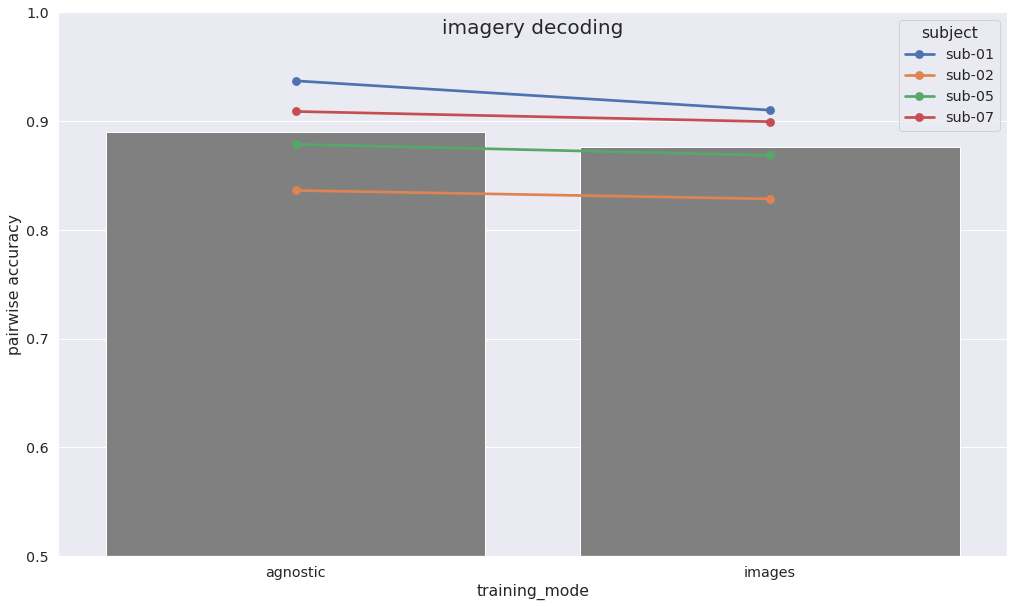

In [33]:
to_plot = filtered.copy()

TRAINING_MODES = ['images', 'agnostic']
METRICS = ['imagery_weak']
sns.set(font_scale=1.3)
plt.figure(figsize=(17,10))
plt.title('imagery decoding', y=0.95, fontsize=20)

to_plot = to_plot[to_plot.metric.isin(METRICS)]
to_plot = to_plot[to_plot.training_mode.isin(TRAINING_MODES)]

ax = sns.barplot(data=to_plot, x="training_mode", y="value", errorbar=None, color='gray')
# ax = sns.scatterplot(data=to_plot, x="subject", y="value", hue="training_mode")
ax = sns.pointplot(data=to_plot, x="training_mode", y="value", hue="subject")

plt.ylabel('pairwise accuracy')
plt.ylim((0.5, 1))
plt.savefig(os.path.join(RESULTS_DIR, f"attention_modulation_imagery.png"), bbox_inches='tight', pad_inches=0, dpi=300)



In [34]:
from scipy.stats import ttest_rel
display(to_plot)
acc_images = to_plot[to_plot.training_mode == 'images'].value
acc_agnostic = to_plot[to_plot.training_mode == 'agnostic'].value
# print(acc_images)
# print(acc_agnostic)
ttest_rel(acc_images, acc_agnostic, alternative='less')

,metric,value,standardized_predictions,latents,model,subject,features,test_features,vision_features,lang_features,training_mode,training_splits,mask,num_voxels,surface,resolution,imagery_samples_weight
63,imagery_weak,0.937143,True,limited_candidate_latents,imagebind,sub-01,avg,avg,vision_features_cls,lang_features_cls,agnostic,train,whole_brain,327684,True,fsaverage7,NaN
369,imagery_weak,0.836327,True,limited_candidate_latents,imagebind,sub-02,avg,avg,vision_features_cls,lang_features_cls,agnostic,train,whole_brain,327684,True,fsaverage7,NaN
674,imagery_weak,0.878776,True,limited_candidate_latents,imagebind,sub-05,avg,avg,vision_features_cls,lang_features_cls,agnostic,train,whole_brain,327684,True,fsaverage7,NaN
913,imagery_weak,0.908980,True,limited_candidate_latents,imagebind,sub-07,avg,avg,vision_features_cls,lang_features_cls,agnostic,train,whole_brain,327684,True,fsaverage7,NaN
1355,imagery_weak,0.910204,True,limited_candidate_latents,imagebind,sub-01,avg,avg,vision_features_cls,lang_features_cls,images,train,whole_brain,327684,True,fsaverage7,NaN
1389,imagery_weak,0.828571,True,limited_candidate_latents,imagebind,sub-02,avg,avg,vision_features_cls,lang_features_cls,images,train,whole_brain,327684,True,fsaverage7,NaN
1422,imagery_weak,0.868571,True,limited_candidate_latents,imagebind,sub-05,avg,avg,vision_features_cls,lang_features_cls,images,train,whole_brain,327684,True,fsaverage7,NaN
1457,imagery_weak,0.899592,True,limited_candidate_latents,imagebind,sub-07,avg,avg,vision_features_cls,lang_features_cls,images,train,whole_brain,327684,True,fsaverage7,NaN


TtestResult(statistic=-3.0261158353870856, pvalue=0.02824226385546064, df=3)

In [61]:
def get_distance_matrix(predictions, originals, metric='cosine'):
    dist = cdist(predictions, originals, metric=metric)
    return dist
    
def dist_mat_to_pairwise_acc(dist_mat, stim_ids, print_details=False, reduce=True):
    if reduce:
        diag = dist_mat.diagonal().reshape(-1, 1)
        comp_mat = diag < dist_mat
        corrects = comp_mat.sum()
        if print_details:
            for i, stim_id in enumerate(stim_ids):
                print(stim_id, end=': ')
                print(f'{comp_mat[i].sum() / (len(comp_mat[i]) - 1):.2f}')
        # subtract the number of elements of the diagonal as these values are always "False" (not smaller than themselves)
        score = corrects / (dist_mat.size - diag.size)
        return score
    else:
        diag = dist_mat.diagonal().reshape(-1, 1)
        comp_mat = diag < dist_mat 
        # print(diag.shape)
        # print(diag)
        acc_per_pred = comp_mat.sum(axis=1) / (len(dist_mat) - 1)

        return acc_per_pred



In [93]:
SURFACE = True

MODEL = "imagebind"

SUBJECTS = ['sub-01', 'sub-02', 'sub-05', 'sub-07']
# SUBJECTS = ['sub-01', 'sub-02']

TRAINING_MODES = ["images", "agnostic"]

BETAS_SUFFIX = 'betas'
BETAS_DIR = os.path.join(FMRI_DATA_DIR, BETAS_SUFFIX)

RESTANDARDIZE_PREDS = [SPLIT_IMAGERY_WEAK]

FEATS = 'default'
TEST_FEATS = 'default'
VISION_FEATS = 'default'
LANG_FEATS = 'default'
FEATS_CONFIG = LatentFeatsConfig(MODEL, FEATS, TEST_FEATS, VISION_FEATS, LANG_FEATS)

all_pairwise_accs = []
for subj in SUBJECTS:
    print(subj)
    for training_mode in TRAINING_MODES:
    
        stim_ids_imagery, _ =  get_stim_info(subj, SPLIT_IMAGERY_WEAK)
    
        latents = get_latents_for_splits(subj, FEATS_CONFIG, [SPLIT_TRAIN, SPLIT_TEST_IMAGES, SPLIT_IMAGERY_WEAK], training_mode)
        latents = standardize_latents(latents)
    
        predictions = load_predictions(BETAS_DIR, subj, training_mode, FEATS_CONFIG, surface=SURFACE)
    
        pred_latents_imagery = predictions[SPLIT_IMAGERY_WEAK]
        if len(RESTANDARDIZE_PREDS)>0:
            print(f'standardizing imagery predictions with {RESTANDARDIZE_PREDS}')
            refs = np.concatenate([predictions[split] for split in RESTANDARDIZE_PREDS])
            transform = StandardScaler().fit(refs)
            pred_latents_imagery = transform.transform(pred_latents_imagery)

        candidate_latents = latents[SPLIT_IMAGERY_WEAK]
        candidate_latent_ids = stim_ids_imagery
        
        dist_mat = get_distance_matrix(pred_latents_imagery, candidate_latents)
        scores = dist_mat_to_pairwise_acc(dist_mat, candidate_latent_ids, reduce=False)
        # print(scores.mean())
        for stim_id, score in zip(stim_ids_imagery, scores):
            all_pairwise_accs.append({'value': score, 'training_mode': training_mode, 'subject': subj, 'stim_id': stim_id})
    

df = pd.DataFrame(all_pairwise_accs)
df['subj_stim_id'] = df['subject'] + '_' + df['stim_id'].astype("string")
# display(df)
values_agnostic = df[df.training_mode == 'agnostic'].sort_values(['subject', 'stim_id'])
values_images = df[df.training_mode == 'images'].sort_values(['subject', 'stim_id'])
display(values_agnostic)
display(values_images)

# plt.figure(figsize=(40, 40))
# ax = sns.pointplot(data=df, x="training_mode", y="value", hue="subj_stim_id")

ttest_rel(values_images.value, values_agnostic.value, alternative='less')

Selected features for imagebind: avg avg vision_features_cls lang_features_cls
sub-01
loading decoder results from: 
 /home/mitja/data/multimodal_decoding/additional_test/whole_brain_decoding/images/sub-01/imagebind_avg_test_avg_vision_features_cls_lang_features_cls_betas_surface_fsaverage7/predictions.p
standardizing imagery predictions with ['imagery_weak']
loading decoder results from: 
 /home/mitja/data/multimodal_decoding/additional_test/whole_brain_decoding/agnostic/sub-01/imagebind_avg_test_avg_vision_features_cls_lang_features_cls_betas_surface_fsaverage7/predictions.p
standardizing imagery predictions with ['imagery_weak']
sub-02
loading decoder results from: 
 /home/mitja/data/multimodal_decoding/additional_test/whole_brain_decoding/images/sub-02/imagebind_avg_test_avg_vision_features_cls_lang_features_cls_betas_surface_fsaverage7/predictions.p
standardizing imagery predictions with ['imagery_weak']
loading decoder results from: 
 /home/mitja/data/multimodal_decoding/addition

,value,training_mode,subject,stim_id,subj_stim_id
50,0.979592,agnostic,sub-01,9800,sub-01_9800
51,0.938776,agnostic,sub-01,11288,sub-01_11288
52,0.979592,agnostic,sub-01,15645,sub-01_15645
53,0.836735,agnostic,sub-01,22563,sub-01_22563
54,1.000000,agnostic,sub-01,26538,sub-01_26538
...,...,...,...,...,...
395,1.000000,agnostic,sub-07,516344,sub-07_516344
396,0.938776,agnostic,sub-07,517685,sub-07_517685
397,1.000000,agnostic,sub-07,561013,sub-07_561013
398,0.979592,agnostic,sub-07,563194,sub-07_563194


,value,training_mode,subject,stim_id,subj_stim_id
0,0.959184,images,sub-01,9800,sub-01_9800
1,0.959184,images,sub-01,11288,sub-01_11288
2,0.979592,images,sub-01,15645,sub-01_15645
3,0.795918,images,sub-01,22563,sub-01_22563
4,0.979592,images,sub-01,26538,sub-01_26538
...,...,...,...,...,...
345,1.000000,images,sub-07,516344,sub-07_516344
346,0.918367,images,sub-07,517685,sub-07_517685
347,1.000000,images,sub-07,561013,sub-07_561013
348,0.979592,images,sub-07,563194,sub-07_563194


TtestResult(statistic=-1.8510886161158275, pvalue=0.032819358638609825, df=199)

# Imagery decoding with varying standardization techniques

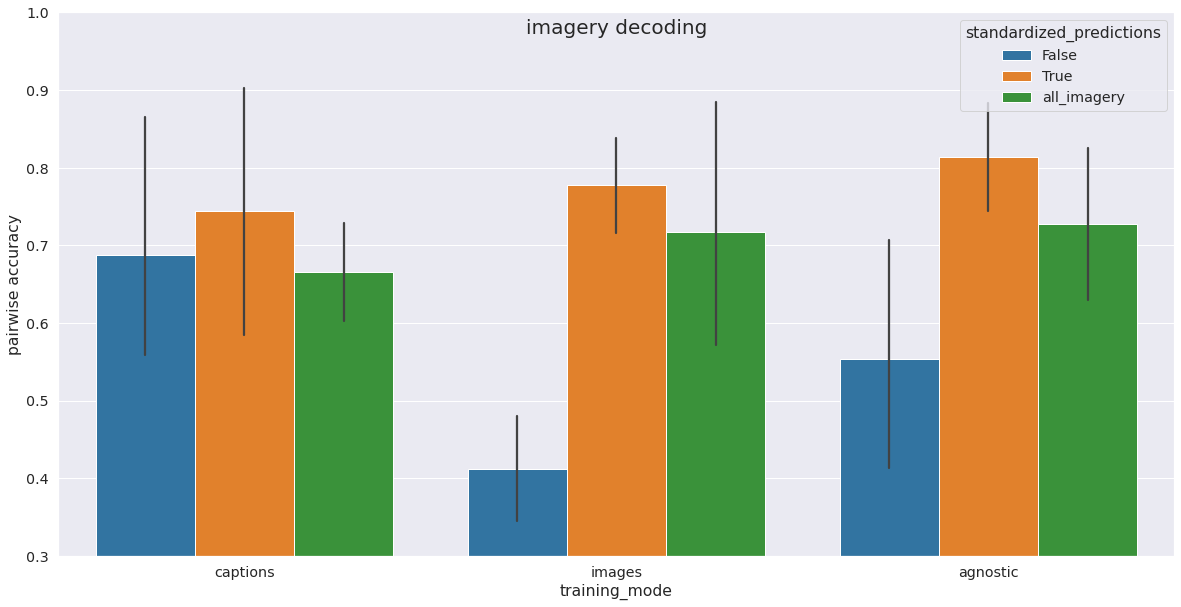

In [94]:
to_plot = data.copy()

LATENT_MODE = 'all_candidate_latents'
# LATENT_MODE = 'limited_candidate_latents'
MASK = 'whole_brain'
TRAINING_SPLITS = 'train'

# to_plot = to_plot[to_plot.standardized_predictions == 'True']
to_plot = to_plot[to_plot.latents == LATENT_MODE]
to_plot = to_plot[to_plot.metric == 'imagery']
to_plot = to_plot[to_plot.surface == True]
to_plot = to_plot[to_plot.training_splits == TRAINING_SPLITS]
to_plot = to_plot[to_plot['mask'] == MASK]

assert len(to_plot) == NUM_SUBJECTS * len(to_plot.standardized_predictions.unique()) * len(to_plot.training_mode.unique())

ORDER = ['captions', 'images', 'agnostic']
HUE_ORDER = None

PALETTE = 'tab10'
sns.set(font_scale=1.3)
plt.figure(figsize=(20,10))
plt.title('imagery decoding', y=0.95, fontsize=20)

ax = sns.barplot(data=to_plot, x="training_mode", y="value", hue="standardized_predictions", order=ORDER, hue_order=HUE_ORDER, palette=PALETTE)
plt.ylabel('pairwise accuracy')
plt.ylim((0.3, 1))
plt.savefig(os.path.join(RESULTS_DIR, f"attention_modulation_imagery.png"), bbox_inches='tight', pad_inches=0, dpi=300)


# Imagery decoding with varying training sets

['train' 'imagery_weak' 'train_imagery_weak']


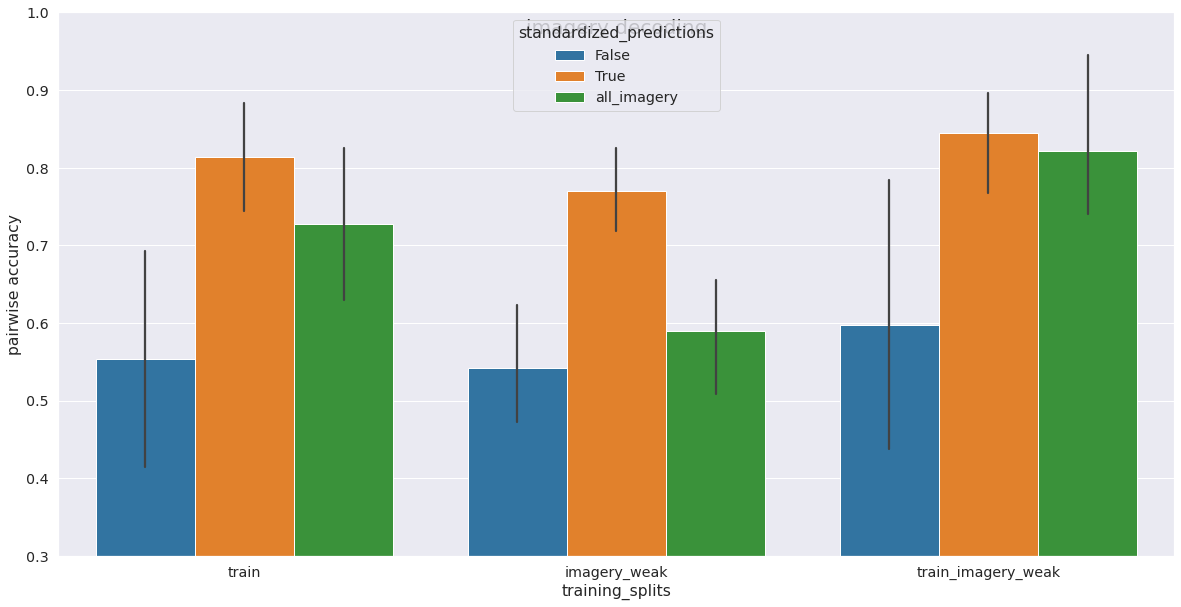

In [95]:
to_plot = data.copy()


LATENT_MODE = 'all_candidate_latents'
# LATENT_MODE = 'limited_candidate_latents'
MASK = 'whole_brain'
TRAINING_SPLITS = 'train'

print(to_plot.training_splits.unique())

# to_plot = to_plot[to_plot.standardized_predictions == 'True']
to_plot = to_plot[to_plot.latents == LATENT_MODE]
to_plot = to_plot[to_plot.metric == 'imagery']
# to_plot = to_plot[to_plot.training_splits == TRAINING_SPLITS]
to_plot = to_plot[to_plot['mask'] == MASK]
to_plot = to_plot[to_plot.surface == True]
to_plot = to_plot[to_plot.training_mode == 'agnostic']
to_plot = to_plot[to_plot.imagery_samples_weight.isna()]

# display(to_plot)
# assert len(to_plot) == NUM_SUBJECTS * len(to_plot.standardized_predictions.unique()) * len(to_plot.training_splits.unique()), to_plot

PALETTE = 'tab10'#['red', 'salmon']
sns.set(font_scale=1.3)
plt.figure(figsize=(20,10))
plt.title('imagery decoding', y=0.95, fontsize=20)

ax = sns.barplot(data=to_plot, x="training_splits", y="value", hue="standardized_predictions", palette=PALETTE)
plt.ylabel('pairwise accuracy')
plt.ylim((0.3, 1))
plt.savefig(os.path.join(RESULTS_DIR, f"attention_modulation_imagery.png"), bbox_inches='tight', pad_inches=0, dpi=300)


# Imagery decoding with varying training sets and sample weight

['train' 'imagery_weak' 'train_imagery_weak']
[   1.   10.  100. 1000.    2.  200.  500.]


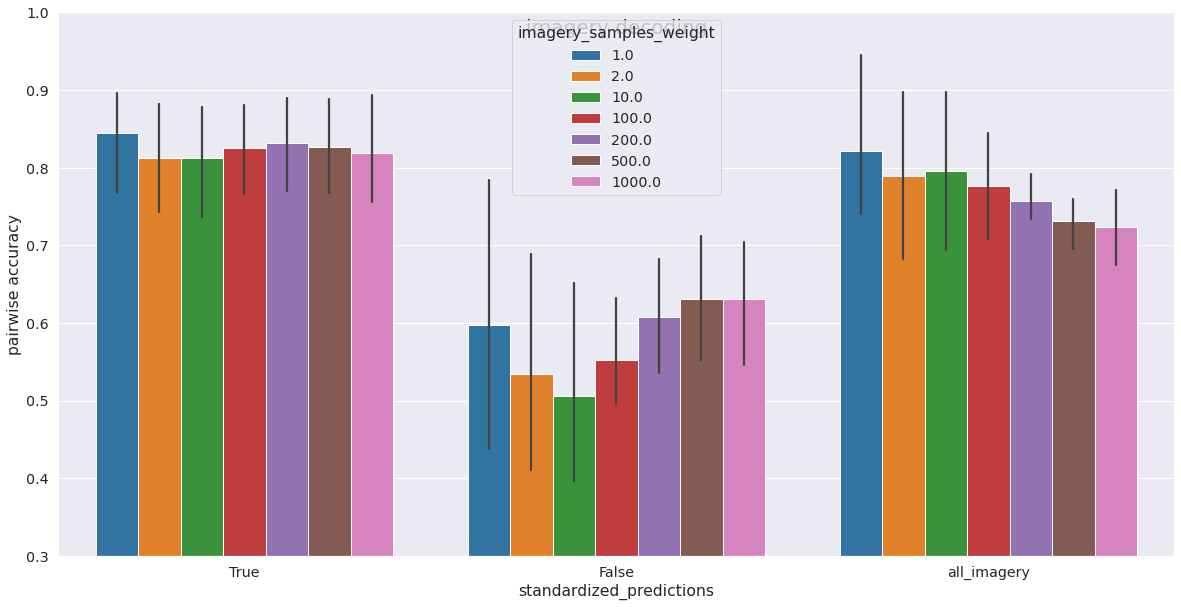

In [96]:
to_plot = data.copy()


LATENT_MODE = 'all_candidate_latents'
# LATENT_MODE = 'limited_candidate_latents'
MASK = 'whole_brain'
TRAINING_SPLITS = 'train_imagery_weak'

print(to_plot.training_splits.unique())

# to_plot = to_plot[to_plot.standardized_predictions == 'True']
to_plot = to_plot[to_plot.latents == LATENT_MODE]
to_plot = to_plot[to_plot.metric == 'imagery']
to_plot = to_plot[to_plot.training_splits == TRAINING_SPLITS]
to_plot = to_plot[to_plot['mask'] == MASK]
to_plot = to_plot[to_plot.surface == True]
to_plot = to_plot[to_plot.training_mode == 'agnostic']
# to_plot = to_plot[to_plot.imagery_samples_weight.isna()]

to_plot.imagery_samples_weight.fillna(1.0, inplace=True)

print(to_plot.imagery_samples_weight.unique())
# display(to_plot)
# assert len(to_plot) == NUM_SUBJECTS * len(to_plot.standardized_predictions.unique()) * len(to_plot.imagery_samples_weight.unique()), to_plot

ORDER = None
HUE_ORDER = np.sort(to_plot.imagery_samples_weight.unique())

PALETTE = 'tab10'#['red', 'salmon']
sns.set(font_scale=1.3)
plt.figure(figsize=(20,10))
plt.title('imagery decoding', y=0.95, fontsize=20)

ax = sns.barplot(data=to_plot, x="standardized_predictions", y="value", hue="imagery_samples_weight", order=ORDER, hue_order=HUE_ORDER, palette=PALETTE)
plt.ylabel('pairwise accuracy')
plt.ylim((0.3, 1))
plt.savefig(os.path.join(RESULTS_DIR, f"attention_modulation_imagery.png"), bbox_inches='tight', pad_inches=0, dpi=300)


In [ ]:
# data = load_results_data()

# to_plot = data.copy()

# # METRIC = "imagery"
# TRAINING_MODE = 'agnostic'
# # TRAINING_MODE = 'images'
# # TRAINING_MODE = 'captions'

# LATENT_MODE = 'all_candidate_latents'
# # LATENT_MODE = 'limited_candidate_latents'
# # MASK = 'whole_brain'

# TRAINING_SPLITS = 'train'


# to_plot = to_plot[to_plot.standardized_predictions == 'True']
# to_plot = to_plot[to_plot.latents == LATENT_MODE]
# to_plot = to_plot[to_plot.training_splits == TRAINING_SPLITS]
# # to_plot = to_plot[to_plot['mask'] == MASK]

# to_plot = to_plot[to_plot.training_mode == TRAINING_MODE]
# # to_plot = to_plot[to_plot.metric == METRIC]

# def shorten_mask_name(name):
#     if name == "whole_brain":
#         return name
#     return os.path.basename(name)
    
# to_plot["mask"] = to_plot["mask"].apply(shorten_mask_name)


# # print(to_plot.groupby(['metric', 'mask']).agg(num_subjects=('value', 'size')).reset_index())
# assert len(to_plot) == NUM_SUBJECTS * len(to_plot.metric.unique()) * len(to_plot['mask'].unique())


# HUE_ORDER = ['test_image_attended', 'test_image_unattended', 'test_caption_attended', 'test_caption_unattended']#, 'imagery', 'imagery_weak'] #'test_image',  'test_caption',
# PALETTE = ['darkblue', 'cornflowerblue', 'darkgreen', 'limegreen', 'red', 'salmon'] #'blue', 'green'
# sns.set(font_scale=1.3)
# plt.figure(figsize=(30,10))
# ax = sns.barplot(data=to_plot, x="mask", y="value", hue="metric", hue_order=HUE_ORDER, palette=PALETTE)
# plt.ylabel('pairwise accuracy')
# plt.ylim((0.5, 1))
# plt.xticks(rotation=85)
# sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

